# WEB'TEN OTOMATİK ÇEKİLEN LİNKLERDEN SÖZLERE ERİŞİM VE VERİLERİN TEMİZLENMESİ

Şimdi ilk adım olarak anasayfadan tüm linkleri çekelim

In [1]:
import requests
from bs4 import BeautifulSoup
#MAİN METOT
linkler=open("harf_link.txt", "wb")

sozurl = "http://www.sarki-sozleri.com/tur/turkce-sarki-sozleri.html"

r = requests.get(sozurl)
soup = BeautifulSoup(r.content, "html.parser")
gelen_veri = soup.find("div", {"class": "main-body"})
gelen_veri = gelen_veri.find_all("div", {"class": "col-lg-8 col-md-8"})

for v in gelen_veri:
    div = v.find_all("div", {"class": "text-center"})
    for d in div:
        href = d.find_all("a")
        for h in href:
            link = h["href"]
            linkler.write(str(link).encode('utf8') + bytes('\n', 'utf8'))
            
linkler.close()


Linkler aşağıdaki resimde görüldüğü üzere dosyaya kaydedildi.

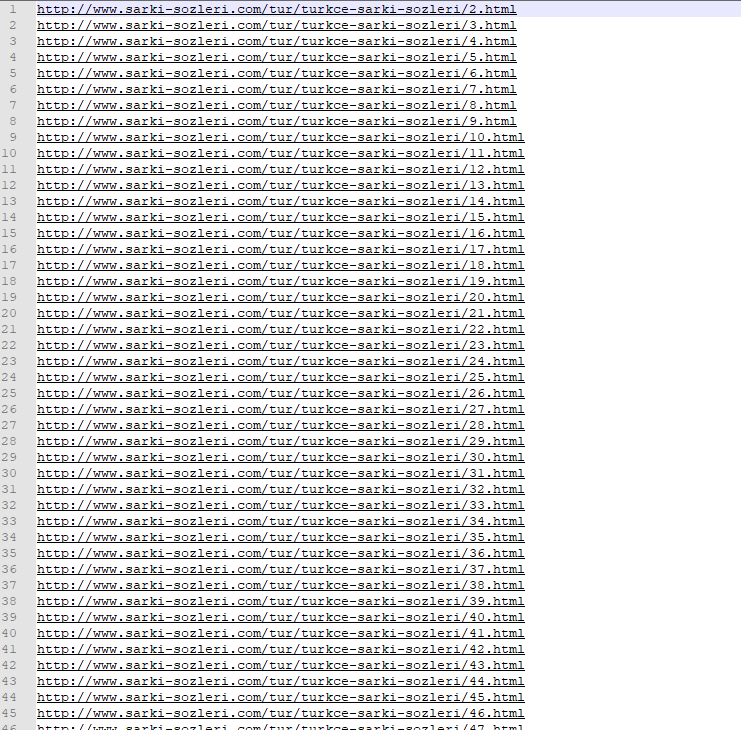

Her linkte bir sayfa barınmaktadır. Bu sayfaların her birinde de aşağıdaki gibi 18 adet şarkı sözü linki bulunmaktadır.Şimdi her linkteki şarkı sözlerinin linklerini çekip farklı bir dosyaya kaydedeceğiz.

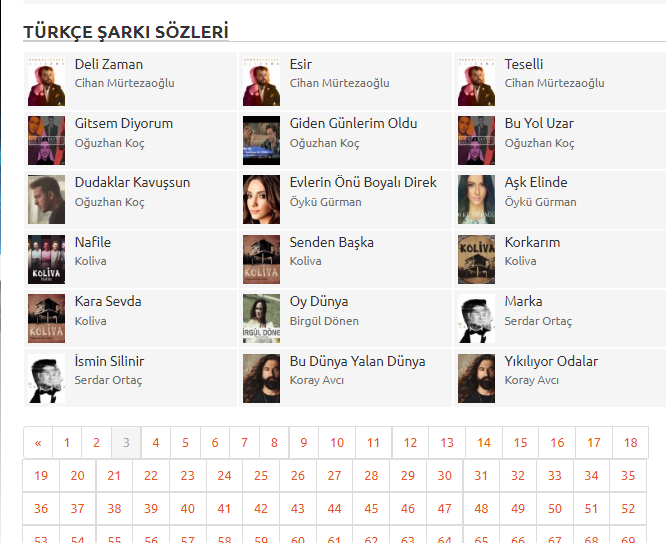

In [2]:
#SÖZLERİN BULUNDUĞU SAYFALARIN LİNKİNİ ÇEKİYORUZ
def linke_git(link):
    
    r = requests.get(link)
    soup = BeautifulSoup(r.content, "html.parser")

    harf_list = soup.find("div", attrs={"class": "main-body"})
    harf_list =harf_list.find("div", attrs={"class": "col-lg-8 col-md-8"})
    harf_list = harf_list.find("ul", attrs={"class": "list-unstyled sarki-listesi"})
    href = harf_list.find_all("a")

    for h in href:
        link = h["href"]
        soz_link.write(str(link).encode('utf8') + bytes('\n', 'utf8'))


In [3]:
#harflerin linkine bağlanalım
linkler_oku=open("harf_link.txt", "r")
soz_link = open("soz_link.txt","wb") #her şarkı sözünün bulunduğu sayfanın linkini bu dosyaya yazacağız
for link in linkler_oku:
    linke_git(link) 
soz_link.close()


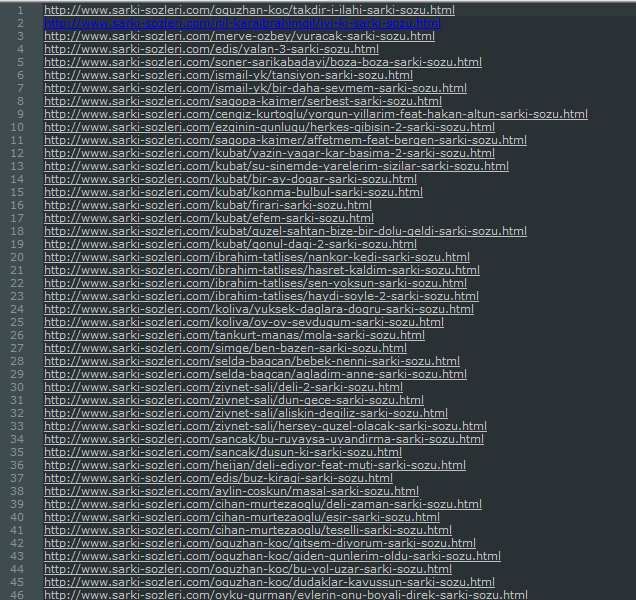

# Üstteki blokta yaklaşık 1500 adet şarkı sözünün linkini çektik. Şimdi aşağıdaki metodu kullanarak bu linklerdeki şarkı sözlerine erişip bu sözleri {sanatçı:,şarkı adı:,türü:,şarkı sözü:} içerecek şekilde MongoDB veritabanına JSON formatında depolayacağız(her kadegoriyi ayrı bir alana depolayacağız)

In [4]:
from pymongo import MongoClient
#ÖNCELİKLE VERİTABANI BAĞLANTIMIZI YAPTIK
MONGODB_URI = "mongodb://kullanici.mlab.com:55768/KlasorAdi" #buraya aşağıdaki resimde işaretli olan kısım yazılacak.
client = MongoClient(MONGODB_URI, connectTimeoutMS=30000)
db = client.get_database("bitirmetezi")
turku=db.turkuM
arabesk=db.arabeskM
pop=db.popM
rap=db.rapM
ilahi=db.ilahiM
karadeniz=db.karadenizM
rock=db.rockM
tsn=db.tsnM
KARISIK=db.KARISIK


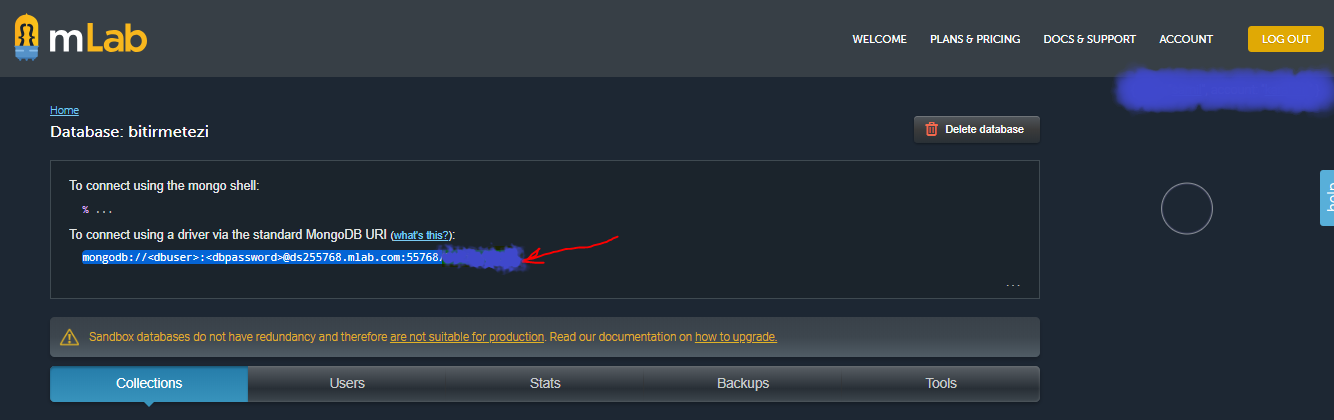

In [5]:
def pushRECORD(record,tur):
    if tur=="1":
        turku.insert_one(record)
    if tur=="2":
        pop.insert_one(record)
    if tur=="3":
        rock.insert_one(record)
    if tur=="4":
        rap.insert_one(record)
    if tur=="5":
        karadeniz.insert_one(record)
    if tur=="6":
        ilahi.insert_one(record)
    if tur=="7":
        tsn.insert_one(record)
    if tur=="8":
        arabesk.insert_one(record)
    KARISIK.insert_one(record)

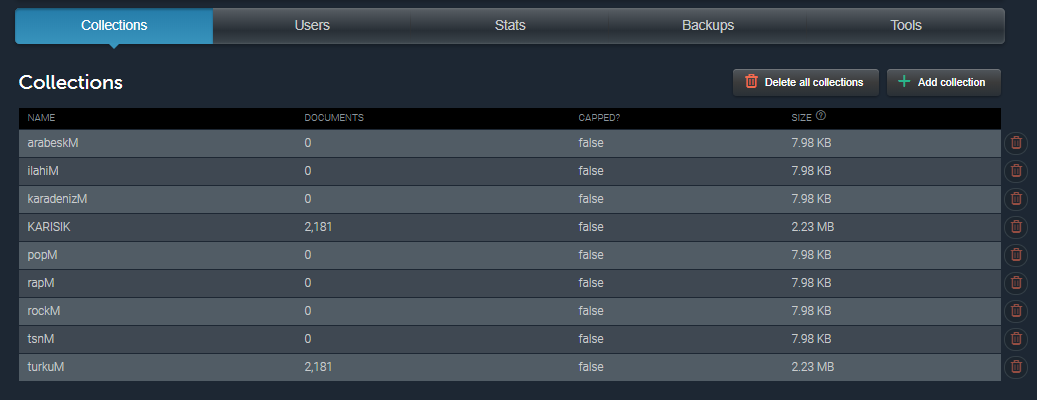

Aşağıdaki metot ise Python'un bir string paketi olan "maketrans" fonksiyonunu kullanarak metindeki sayıları ve noktalama işaretlerini temizlememize yardımcı oluyor.

In [8]:

def temizle(metin):

    cevirici = str.maketrans('', '', punctuation)
    metin = metin.translate(cevirici)
    cevirici = str.maketrans('', '', digits)
    metin = metin.translate(cevirici)
    duzelt = str.maketrans('I', "l")
    metin = metin.translate(duzelt)
    duzelt2 = str.maketrans('ß', "b")
    metin = metin.translate(duzelt2)
    
    return metin

In [9]:
def Turku_bilgiCek(link):
    tur="1"
    r = requests.get(link)
    soup = BeautifulSoup(r.content, "html.parser")
    sarkiSozu = soup.find("p")
    sarkiAdi= soup.find("span")
    sanatci=soup.find("li", attrs={"class": "kaynakyore"})
    sanatci=sanatci.find("a")
    
    sanatci=sanatci.text
    sarkiAdi= sarkiAdi.text
    sarkiSozu = sarkiSozu.text + " "

    sarkiSozu=sarkiSozu.replace('\n', ' ')
    sarkiSozu=temizle(sarkiSozu)
    sarkiAdi=sarkiAdi.lower()
    sanatci=sanatci.lower()
    sarkiSozu=sarkiSozu.lower()
    sarkiAdi=temizle(sarkiAdi)
    sanatci=temizle(sanatci)
    sarkiSozu=temizle(sarkiSozu)
    
    record = {"sanatci":sanatci,"sarki": sarkiAdi,"tur":tur,"sarki sozu" : sarkiSozu}
    pushRECORD(record,tur)

In [10]:
def Turku_harfeGit(harfUrl):
    r = requests.get(harfUrl)
    soup = BeautifulSoup(r.content, "html.parser")
    gelen_veri1=soup.find_all("li", attrs={"class": "veri1 turkuadi"})
    gelen_veri2=soup.find_all("li", attrs={"class": "veri2 turkuadi"})
    a=0
    for i in gelen_veri1:
        href = i.find("a")
        link = href["href"]
        
        ylink="https://www.turkudostlari.net/"+link
        Turku_bilgiCek(ylink)
        
        
    for i in gelen_veri2:
        href = i.find("a")
        link = href["href"]
        
        ylink="https://www.turkudostlari.net/"+link
        Turku_bilgiCek(ylink)


In [13]:
# BU KISIMDA TÜRKÜLERİ FARKLI BİR SİTEDEN ÇEKİYORUZ
import requests
from bs4 import BeautifulSoup
import json
from string import punctuation, digits
#MAİN METOT
harf_link = open("harf_link.txt","wb")
harfUrl=" "
a =1
while a < 2:
    harfUrl="https://www.turkudostlari.net/liste.asp?x=1&s="+str(a)
#     harf_link.write(str(harfUrl).encode('utf8') + bytes('\n', 'utf8'))
    Turku_harfeGit(harfUrl)
    a += 1
    harfUrl=" "

In [13]:
def ilahi_sozbul(link,sayac2):
    tur="6"
    r = requests.get(link)
    soup = BeautifulSoup(r.content, "html.parser")
    soz=soup.find("main", {"id": "main"})
    sarki=soup.find("h2", {"class": "entry-title"})
    sarkiAdi=sarki.text

    sanatci = soup.find("span", {"class": "cat-links"})
    sanatci=sanatci.find("a").text
    sarkiSozu= soz.find_all("p")
    
    soz=" "
    for p in sarkiSozu:
        soz += p.text+" "
    soz=soz.replace('\n', ' ')
    sarkiSozu=temizle(soz)
    sarkiAdi=sarkiAdi.lower()
    sanatci=sanatci.lower()
    soz=soz.lower()
    sarkiAdi=temizle(sarkiAdi)
    sanatci=temizle(sanatci)
    sarkiSozu=temizle(soz)
    
    record = {"sanatci":sanatci,"sarki": sarkiAdi,"tur":tur,"sarki sozu" : sarkiSozu}
    pushRECORD(record,tur) 
    
    gelen_veri = soup.find("nav", {"class": "navigation pagination"})
    gelen_veri = gelen_veri.find("div", {"class": "nav-links"})

    gelen_veri=gelen_veri.find_all("a")
    sayac=0
    
    for href in gelen_veri:
        if sayac==5:
            ylink = href["href"]
            if sayac2==300:
                break
            else:
                sayac2+=1
                ilahi_sozbul(ylink,sayac2)
        sayac+=1
        

In [14]:
# İlave ilahi çektik bu kısımda
import requests
from bs4 import BeautifulSoup
import select
import json
from string import punctuation, digits

sozurl = "https://ilahisozleri.xyz/page/3/"
sayac2=0
ilahi_sozbul(sozurl,sayac2)


    

Buraya kadar ki metotlar çekilen söz metinlerinin düzenlenmesini ve veritabanına kaydedilmesini gerçekleştiriyordu.
Şimdi asıl işlemimiz olan webten her şarkının sözlerini,şarkıcı ismini,kategorisini(tür),ve şarkının ismini ayrı ayrı çekip veritabanına kaydetme işlemini gerçekleştireceğiz.

In [12]:
from string import punctuation, digits

def soz_cek(link,n):
    s=0
    r = requests.get(link)
    soup = BeautifulSoup(r.content, "html.parser")
    try:
        harf_list = soup.find("div", attrs={"class": "main-body"})
        harf_list = harf_list.find("div", attrs={"class": "col-lg-8 col-md-8"})
        san=harf_list.find("ul", attrs={"breadcrumb mt14"}).select("li:nth-of-type(3)")
        sarkı = harf_list.find("ul", attrs={"class": "breadcrumb mt14"}).select("li:nth-of-type(4)")
        sarkiTuru=harf_list.find("ul", attrs={"class": "list-unstyled ozellik-liste"}).select("li:nth-of-type(2)")
        for v in sarkiTuru:
            div = v.find_all("div", {"class": "ozellik-icerik"})
            for d in div:
                href = d.find_all("a")
                for h in href:
                    if s == 1:
                        tur = h.text
                        if tur=="Türkü Sözleri":
                            tur="1"
                        elif tur=="Pop Şarkı Sözleri":
                            tur="2"
                        elif tur=="Rock Şarkı Sözleri":
                            tur="3"
                        elif tur=="Rap Şarkı Sözleri":
                            tur="4"
                        elif tur=="Karadeniz Şarkı Sözleri":
                            tur="5"
                        elif tur=="İlahi Sözleri":
                            tur="6"
                        elif tur=="Türk Sanat Müziği":
                            tur="7"
                        elif tur=="Arabesk Şarkı Sözleri":
                            tur="8"

                    else:
                        tur = " "
                        s+=1

        for i in san:
            sanatci=i.text
        for i in sarkı:
            sarkiAdi=i.text

        soz_p=harf_list.find("div", attrs={"class": "text-justify"})
        soz_p=soz_p.find_all("p")
        sarkiAdi=sarkiAdi.lower()
        sarkiAdi=convertAscii(sarkiAdi)
        sanatci = convertAscii(sanatci)
        sanatci = sanatci.lower()

        sarkıSozu = ""
        if soz_p=="soz bulunamadi":
            sarkıSozu=soz_p
        else:
            for p in soz_p:
                sarkıSozu += p.text+"  "

        sarkıSozu = convertAscii(sarkıSozu)
        sarkıSozu=sarkıSozu.lower()

        sarkiAdi=convertAscii(sarkiAdi)
        sanatci = convertAscii(sanatci)
        sarkıSozu=convertAscii(sarkıSozu)


        record = {"sanatci":sanatci,"sarki": sarkiAdi,"tur":tur,"sarki sozu" : sarkıSozu}

        pushRECORD(record,tur) 

    except (AttributeError,ValueError) as hata:
        print("hata ", hata)
        
soz_link =open("soz_link.txt", "r")
for n,link in enumerate(soz_link):
    soz_cek(link,n)




hata  'NoneType' object has no attribute 'find_all'
hata  'NoneType' object has no attribute 'find'


In [ ]:
### import codecs
import csv
from pymongo import MongoClient
from collections import Counter

# popF= codecs.open("pop.txt","r+","utf8") #Burada "r+" kipiyle dosyamızı hem "okuma" hem "yazma" kipinde açtık.
# rockF= codecs.open("rock.txt","r+","utf8")
# tsnF= codecs.open("tsn.txt","r+","utf8")
# arabeskF= codecs.open("arabesk.txt","r+","utf8")
# rapF= codecs.open("rap.txt","r+","utf8")
# karadenizF= codecs.open("karadeniz.txt","r+","utf8")
# ilahiF= codecs.open("ilahi.txt","r+","utf8")
# turkuF= codecs.open("turku.txt","r+","utf8")
KARISIKF= codecs.open("yen.txt","r+","utf8")

def kategDepola(data,kategF):

    s = data.find()

    
    f =  codecs.open('yenKarisik.csv', 'w',"utf8")
    w = csv.DictWriter(f, fieldnames = ['sarki_adi','tur','sanatci','sarki_sozu'], delimiter=',')
    w.writeheader()

    kelime_say=0
    for item in s:
        soz = item["sarki sozu"]
        SPsoz=soz.split()
        kelime_say+=len(SPsoz) #burada kelime sayısını hesaplıyoruz
        tur= item["tur"]
        my_dict = {"sarki_adi": item["sarki"], "sarki_sozu": item["sarki sozu"], "tur": item["tur"], "sanatci": item["sanatci"]}
        w.writerow(my_dict)
        kategF.write(soz + "\n")
    f.close()    
#     kategF.close()
    print(tur,'Toplam kelime sayısı:', kelime_say)
    
    metinF=""
    for n,line in enumerate(kategF):
        metinF+=line
    metinF=metinF.split()  
    kelime_sayi = Counter(metinF)
    print(type(kelime_sayi), '\n')
    for kelime in kelime_sayi.most_common(10):
        print(kelime)
    
        
#Öncelikle veritabanına bağlanıp her kategorinin bağlantısını bir değişkene atacağız ve bağlantıyla birlikte
#dosya değişkenini "kategDepola" metoduna göndereceğiz.
connection = MongoClient('mongodb://kullanici.mlab.com:55768/KlasorAdi')
db = connection.bitirmetezi
data1 = db.turkuM
data2 = db.popM
data3 = db.rockM
data4 = db.rapM
data5 = db.karadenizM
data6 = db.ilahiM
data7 = db.tsnM
data8 = db.arabeskM
data9 = db.KARISIK


kategDepola(data1,turkuF)
kategDepola(data2,popF)
kategDepola(data3,rockF)
kategDepola(data4,rapF)
kategDepola(data5,karadenizF)
kategDepola(data6,ilahiF)
kategDepola(data7,tsnF)
kategDepola(data8,arabeskF)
kategDepola(data9,KARISIKF)





In [64]:
#"stopWords" metodu ile yaygın kullanılan kelimeleri metinden çıkarıyoruz 
def stopWords(kelime):

        common_words = set(['a', 'acaba', 'ama', 'ancak', 'arada',
    'asla', 'az', 'bana', 'bazen', 'belki', 'ben', 'benden', 'beni', 'benim', 'beri',  'bile', 
    'bilhassa', 'bin', 'bir', 'biraz', 'biri', 'birisi',
    'biz', 'bizden', 'bize', 'bizi', 'bizim',
     'bu', 'buna', 'bunda', 'bundan', 'bunlar',
    'bunu', 'bunun', 'burada','da', 'daha', 'dahi', 'dan', 'de', 'defa',
    'diye', 'doksan', 'dokuz',
    'e', 'edecek', 'eden', 'ederek',
    'edilecek', 'ediliyor', 'edilmesi', 'ediyor', 'elbette', 'elli', 'en', 'etmesi',
    'etti', 'fakat', 'falan', 'filan', 'gene',
    'gerek', 'gibi', 'hala', 'halde', 'halen', 'hangi', 'hangisi', 'hani', 'hatta',
    'hem', 'hep', 'hepsi', 'her', 'herhangi', 'herkes', 'herkese', 'herkesi', 'herkesin',
    'i','iki', 'ile', 'ilgili', 'ise', 'itibaren', 'itibariyle', 'kadar',
     'kendi', 'kendilerine','böyle', 'kendine', 'kendini', 'kendisi', 'kendisine', 
    'kendisini', 'kez', 'ki', 'kim', 'kime', 'kimi', 'kimin', 'kimisi', 'kimse',
    'madem', 'mi','milyar', 'milyon', 'mu',"nasıl" 'ne', 'neden',
    'nedenle', 'nerde', 'nerede', 'nereye', 'neyse', 'nin', 'niye',
    'nun', 'o', 'olan', 'olarak', 'oldu',
    'olmak', 'olmayan', 'olmaz', 'olsa', 'olsun', 'olup', 'olur', 'olur', 'olursa', 
    'oluyor', 'on','ona', 'ondan', 'onlar', 'onlara', 'onlardan',
    'onu', 'onun', 'orada','şu',
    'otuz','oysa','yılında', 'pek', 'sana','nasıl', 'sanki', 'sanki', 'al',
    'sekiz', 'seksen', 'sen', 'senden', 'seni', 'senin','siz', 'siz', 'sizden', 'sizden', 
    'size', 'sizi',"aşk", 'sizi','şarkısının', 'sizin', 'sizin', 'sonra', 'ta', 'tabii', 'tam', 'tamam', 'tamamen',
    'trilyon','u', 'un',"ceza", 'var','ve', 'veya', 'ya', 'yani', 'yapacak', 'yapmak', 'ye', 'yedi', 'yerine', 
    "ye",'yine', 'yirmi', 'yoksa',"AŞK", 'yu', 'zaten', 'zira','değil','x','al',"musun",
    'zxtest',"çok","ne","bi","hiç","yok","bak","gün","için","şarkısı","şarkı","güzel","mı","gel","müzik","nakarat",'şey','artık'])
        return [word for word in kelime if word not in common_words ]



Alttaki metot ile her türde en çok kullanılan kelimeleri tespit ediyoruz.

In [62]:
from collections import Counter
def frekansBul(kategF,n):
    metinF = ""
    for line in kategF:
        metinF += line
    metinF = metinF.split()
    metinF=stopWords(metinF)
#     print(metinF)
    
    kelime_sayi = Counter(metinF)
    

    liste_kelime = []    
    liste_adet = []
    newList =[]
    print(n,"\n")
    print(type(kelime_sayi), '\n')
    for kelime in kelime_sayi.most_common(5):
        print(kelime)
        liste_kelime.append(kelime[0])
        liste_adet.append(kelime[1])
#     if n=="KARISIK":
#         Klist_words=liste_kelime
#         f =  codecs.open('PandasCSVfile.csv', 'w',"utf8")
#         w = csv.DictWriter(f,Klist_words)
#         w.writeheader()
#     for lst in Klist_words:
#         wordcount = Counter(metinF)
#         for item in wordcount: 
#             if lst==wordcount[1]:
#                 newList.append(wordcount[1])
                
        
#     my_dict = {Klist_words[0]: newList[0],Klist_words[1]: newList[1],Klist_words[2]:newList[2],Klist_words[3]:newList[3],Klist_words[4]:newList[4]}
#     w.writerow(my_dict)
#         kelime_say=0
#         for item in s:
#             soz = item["sarki sozu"]
#             SPsoz=soz.split()
#             kelime_say+=len(SPsoz) #burada kelime sayısını hesaplıyoruz
#             tur= item["tur"]
#             my_dict = {"sarki_adi": item["sarki"], "sarki_sozu": item["sarki sozu"], "tur": item["tur"], "sanatci": item["sanatci"]}
#             w.writerow(my_dict)
#             kategF.write(soz + "\n")
    
#     matrix = [[Liste[i] for i in range(5)] for j in range(5)]
#     pprint.pprint(matrix)
#     f =  codecs.open('frekans.csv', 'w',"utf8")
#     w = csv.DictWriter(f, fieldnames = [Liste])
#     w.writeheader()        

    print(liste_kelime)
    print(liste_adet)
    

    print("****************************************************************")
  


Bu metot aracılığıyla en çok kullanılan belli sayıda kelimenin türlere göre dağılımını inceleyecegiz.

    Şimdi her tür için ayrı ayrı kelime frekans bulup her türde en fazla kullanılan 10 kelimeyi bulacağız.

In [65]:
import codecs
import csv
import pprint

from collections import Counter
        
popF= codecs.open("pop.txt","r+","utf8") #Burada "r+" kipiyle dosyamızı hem "okuma" hem "yazma" kipinde açtık.
rockF= codecs.open("rock.txt","r+","utf8")
tsnF= codecs.open("tsn.txt","r+","utf8")
arabeskF= codecs.open("arabesk.txt","r+","utf8")
rapF= codecs.open("rap.txt","r+","utf8")
karadenizF= codecs.open("karadeniz.txt","r+","utf8")
ilahiF= codecs.open("ilahi.txt","r+","utf8")
turkuF= codecs.open("turku.txt","r+","utf8")
# KARISIKF= codecs.open("KARISIK","r+","utf8")

# frekansBul(KARISIKF,n="KARISIK")
frekansBul(turkuF,n="TÜRKÜ")
frekansBul(popF,n="POP")
frekansBul(rockF,n="ROCK")
frekansBul(rapF,n="RAP")
frekansBul(karadenizF,n="KARADENİZ")
frekansBul(ilahiF,n="İLAHİ")
frekansBul(tsnF,n="TÜRK SANAT MÜZİĞİ")
frekansBul(arabeskF,n="ARABESK")


TÜRKÜ 

<class 'collections.Counter'> 

('aman', 1582)
('yar', 1057)
('ah', 475)
('oy', 455)
('gelin', 421)
['aman', 'yar', 'ah', 'oy', 'gelin']
[1582, 1057, 475, 455, 421]
****************************************************************
POP 

<class 'collections.Counter'> 

('hadi', 214)
('ah', 191)
('zaman', 188)
('yer', 183)
('şimdi', 182)
['hadi', 'ah', 'zaman', 'yer', 'şimdi']
[214, 191, 188, 183, 182]
****************************************************************
ROCK 

<class 'collections.Counter'> 

('son', 148)
('hayat', 123)
('zaman', 122)
('dünya', 118)
('şimdi', 114)
['son', 'hayat', 'zaman', 'dünya', 'şimdi']
[148, 123, 122, 118, 114]
****************************************************************
RAP 

<class 'collections.Counter'> 

('rap', 596)
('hadi', 496)
('tek', 404)
('aynı', 265)
('zaman', 240)
['rap', 'hadi', 'tek', 'aynı', 'zaman']
[596, 496, 404, 265, 240]
****************************************************************
KARADENİZ 

<class 'collections.Counter

Şimdi csv dosyamızdaki verileri bir tablo şeklinde gösterelim.

In [2]:

import pandas as pd
import numpy as np
import codecs

g =  codecs.open('mycsvfile_Test.csv', 'r+',"utf8")

df_egitimVeri = pd.read_csv('mycsvfile.csv')
df_testVeri = pd.read_csv('mycsvfile_Test.csv')
df_testVeri

,tur,sarki_adi,sanatci,sarki_sozu
0,4,dayan,allame,verse bol keko tektip düşümcem kollektif bom ...
1,2,armağansın,funda arar,tuttuğumda elini yürekte can sesi var gördüğüm...
2,2,unutur mu bir kadın,funda arar,aşk yaralı ayrılık çiçek açtıgözlerim bulut bu...
3,2,ayrılık kapısı,ezginin günlüğü,kalmak gitmenin yarısı olsa tamamı sevda eder ...
4,2,aşk zamanı,ezginin günlüğü,i̇stemem yaşamak içinbaşka nedentek elime doku...
5,3,her şey i̇nsanlar i̇çin,şebnem ferah,çok parçalandım parçalandıkça çoğaldım diye in...
6,2,ara beni lütfen,kenan doğulu,belki haberin yok her şeyi duydum belki yüzün ...
7,,yaşındayım,taylan kaya,NaN
8,3,i̇ki aşk feat i̇rem candar,teoman,NaN
9,3,daha i̇yi olmaz mıydı,şebnem ferah,ben otuz yaşında hayatın ortasında küçücük şey...
